# Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Helper Functions

In [2]:
def crop_and_pad_to_square(image):


    if isinstance(image, Image.Image):
        image = TF.to_tensor(image) 
        
    # Convert to grayscale
    gray = torch.mean(image, dim=0, keepdim=True)
    gray_float = gray.float()
    gray_uint8 = (gray_float * 255.0).byte() 

    # Create binary mask
    binary_mask = (gray_uint8 > 25).float() 

    # Find non-zero elements
    non_zero_indices = torch.nonzero(binary_mask[0])  

    if non_zero_indices.size(0) == 0: 
        return image

    # Get the bounding box
    top_left = torch.min(non_zero_indices, dim=0)[0]
    bottom_right = torch.max(non_zero_indices, dim=0)[0]

    # Crop the image to the bounding box
    cropped_image = image[:, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
    cropped_height = bottom_right[0] - top_left[0]
    cropped_width = bottom_right[1] - top_left[1]

    # Pad the image to make it square
    if cropped_width > cropped_height:
        # Pad height to match width
        padded_image = F.pad(cropped_image, (0, 0, (cropped_width - cropped_height) // 2, (cropped_width - cropped_height + 1) // 2))
    elif cropped_height > cropped_width:
        # Pad width to match height
        padded_image = F.pad(cropped_image, ((cropped_height - cropped_width) // 2, (cropped_height - cropped_width + 1) // 2, 0, 0))
    else:
        padded_image = cropped_image  

    return padded_image

class CropAndPadToSquare:
    def __call__(self, image):
        return crop_and_pad_to_square(image)

## Create DataSet

In [3]:
class OcularDiseaseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):

        self.img_dir = img_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_id = self.df.iloc[idx]['ID']
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        
        # Load
        image = Image.open(img_path).convert("RGB")
    
        other_conditions = self.df.iloc[idx][['DR', 'MH', 'ODC', 'TSLN', 'DN', 'MYA', 'ARMD']].values
        label = torch.tensor([ *other_conditions], dtype=torch.float32)
        
        # transformations 
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    CropAndPadToSquare(),
    transforms.Resize((512, 512)), 

])

train_dataset = OcularDiseaseDataset(img_dir="../../data/RFMiD/img/Train", csv_file="../../data/RFMiD/labels/Filtered_Train.csv", transform=transform)
validation_dataset = OcularDiseaseDataset(img_dir="../../data/RFMiD/img/Validation", csv_file="../../data/RFMiD/labels/Filtered_Validation.csv", transform=transform)
test_dataset = OcularDiseaseDataset(img_dir="../../data/RFMiD/img/Test", csv_file="../../data/RFMiD/labels/Filtered_Test.csv", transform=transform)

In [5]:
image, label = train_dataset[0] 
image = image.permute(1, 2, 0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


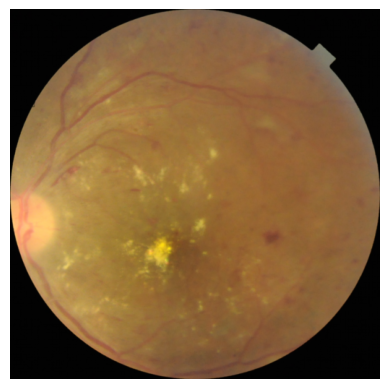

In [6]:


# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
# plt.title(f"Label: {label}")  # Show label in the title
plt.show()